In [1]:
#######################     LIBRARIES     ##########################
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tensorflow as tf
import sys
import os

from progressive_network import MultifidelityNetwork

from multifidelity_utils import compute_randomized_SVD, custom_loss, load_navier_stokes, load_mesh, plot_snapshot, sliding_windows

In [2]:
#######################     CONFIGURATIONS     ##########################
# Configuration
class Config:
    """Configuration class for the multifidelity network."""
    # General settings
    SEED = 10
    MODEL_PATH = "./models/"
    DATA_PATH = "./data/"
    FIGURE_PATH = "./figures/"
    SCALING = True
    TRAIN_MODELS = False
    SAVE_MODELS = False
    
    # POD configuration
    N_POD_LARGE = 64
    N_DOF = 3899
    OUTFLOW_DOFS = list(range(177, 177+20))
    
    # Training parameters
    N_SIMULATIONS = 3

    # Model hyperparameters
    HPARAMS = {
        'lr': 1e-3,
        'kernel_init': 'glorot_uniform',
        'opt': 'Adam',
        'activation': 'tanh',
        'layers_encoder': [20],
        'layers_decoder': [20, 20],
        'l2weight': 1e-5,
        'Nepo': 2500,
        'patience': 100,
        'sequence_length': 80,
        'sequence_freq': 10,
        'concatenate': True,
        'rescale': True
    }

config = Config()

# Set random seeds for reproducibility
tf.random.set_seed(config.SEED)
np.random.seed(config.SEED)

# Check GPU availability
print("GPU devices:", tf.config.list_physical_devices('GPU'))

GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
########################   DATA     ##########################
#Time
t0 = 0.
T_test = 20. #Time for which we observe LF data
T_train = 15. #Time for which we observe both LF and HF data
dt = 0.05
t_train = np.arange(t0, T_train, dt)
Nt_train = len(t_train)
t_test = np.arange(t0, T_test, dt)
Nt_test = len(t_test)

#Parameters
mu_min = 30
mu_max = 100

#Load data train
N_mu_train = 15
mu_train = np.linspace(mu_min, mu_max, N_mu_train, endpoint = True)
vel_train, drag_train, lift_train = load_navier_stokes(
    config.DATA_PATH, mu_train, "train", t0, T_train, dt, verbose=1
)
# Compute magnitude of velocity
vel_magnitude_train = np.sqrt(
    vel_train[:, :, 0:config.N_DOF] ** 2 + vel_train[:, :, config.N_DOF : config.N_DOF * 2] ** 2
)
u_hf = vel_magnitude_train

# Load data test
N_mu_test = 5
mu_test = np.array([37, 48, 63, 78, 92])
vel_test, drag_test, lift_test = load_navier_stokes(
    config.DATA_PATH, mu_test, "test", t0, T_test, dt, verbose=1
)

# Compute magnitude of velocity
vel_magnitude_test = np.sqrt(
    vel_test[:, :, 0:config.N_DOF] ** 2 + vel_test[:, :, config.N_DOF : config.N_DOF * 2] ** 2
)
u_hf_test = vel_magnitude_test

Loaded data for param =  [ 30.  35.  40.  45.  50.  55.  60.  65.  70.  75.  80.  85.  90.  95.
 100.]
Snap shape =  (15, 300, 7798)
Drag shape =  (15, 300, 1)
Lift shape =  (15, 300, 1)
Loaded data for param =  [37 48 63 78 92]
Snap shape =  (5, 400, 7798)
Drag shape =  (5, 400, 1)
Lift shape =  (5, 400, 1)


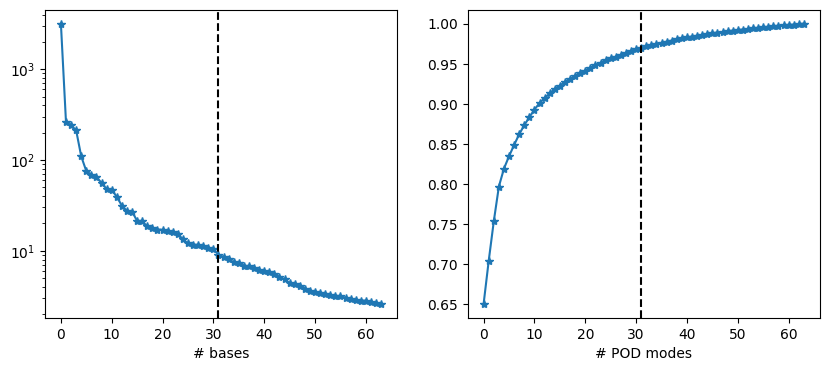

In [4]:
#########################   Proper Orthogonal Decomposition (POD)   ##########################
'''
Run POD on HF training data
'''
#Reshape for POD
u_hf_pod = np.reshape(u_hf.T, (config.N_DOF, -1), 'F')

#POD on HF training data
POM_u, S_u = compute_randomized_SVD(u_hf_pod, config.N_POD_LARGE, config.N_DOF, 1)

n_POD = 32

plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(S_u,'*-')
plt.axvline(x = n_POD-1, color = 'k', linestyle = '--')
plt.yscale('log')
plt.xlabel('# bases')

plt.subplot(122)
plt.plot(np.cumsum(S_u)/np.sum(S_u),'*-')
plt.axvline(x = n_POD-1, color = 'k', linestyle = '--')
plt.xlabel('# POD modes')
plt.show()

POM_u = POM_u[:,:n_POD]
S_u = S_u[:n_POD]

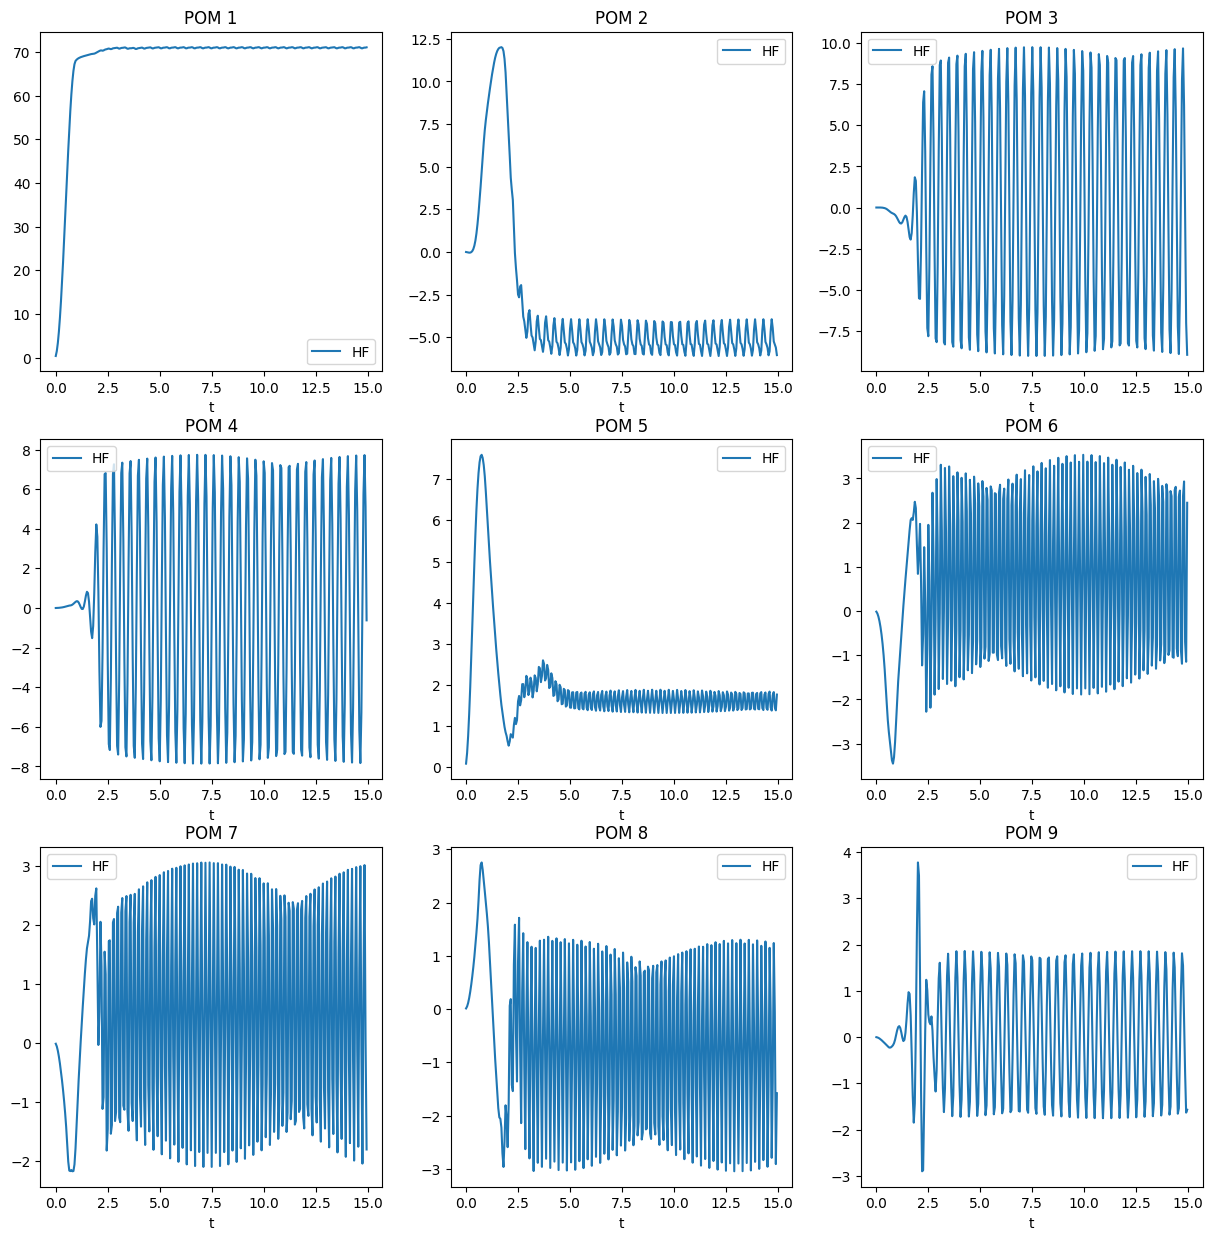

In [5]:
#########################   PROJECTION ONTO POD BASIS    ##########################
u_hf_test_pod = np.reshape(u_hf_test.T, (config.N_DOF, -1), 'F')

uhf_train = u_hf_pod.T @ POM_u
uhf_test = u_hf_test_pod.T @ POM_u

#Reshape to make data suitable to LSTM network
uhf_train = np.reshape(uhf_train, (N_mu_train, Nt_train, -1))
uhf_test = np.reshape(uhf_test, (N_mu_test, Nt_test, -1))

#Plot POD coefficients: LF vs HF
fig = plt.figure(figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(331 + i)
    # plt.plot(t_lf, ulf_train[-1,:,i], label = 'LF')
    plt.plot(t_train, uhf_train[-1, :, i], label = 'HF')
    ax.title.set_text('POM ' + str(i+1))
    plt.xlabel('t')
    plt.legend()
plt.show()

In [6]:
#########################   LSTM NN PREPROCESS    ##########################
#Scaling
if config.SCALING:
    scale = np.sqrt(S_u)
    scale_param = np.max(np.abs(mu_train))
    scale_time = np.max(np.abs(t_train))
else:
    scale =  1.
    scale_param = 1.
    scale_time = 1.

In [7]:
#########################     MODEL 1: PREPROCESS    ##########################
###############################################################################
'''
As first model we consider only the time and the parameter as input
and a feed-forward neural network as model
'''

### Inputs (time and param)
# train
t_train_in = np.tile(t_train, N_mu_train) / scale_time
mu_train_in = np.repeat(mu_train, Nt_train) / scale_param
x1 = np.vstack((t_train_in, mu_train_in)).transpose()
# test
t_test_in = np.tile(t_test, N_mu_test) / scale_time
mu_test_in = np.repeat(mu_test, Nt_test) / scale_param
x1_test = np.vstack((t_test_in, mu_test_in)).transpose()

### Output (HF solutions)
#train
y1 = uhf_train / scale
#test
y1_test = uhf_test / scale
yhf_test = uhf_test / scale

### Reshape to be suited for time-series
t_train_lstm = np.tile(t_train, N_mu_train).T.reshape(N_mu_train,-1,1) / scale_time
mu_train_lstm = np.repeat(mu_train, Nt_train).reshape(N_mu_train,-1,1) / scale_param
x1_lstm = np.concatenate((t_train_lstm, mu_train_lstm), axis = 2)
y1_lstm = uhf_train / scale

t_test_lstm = np.tile(t_test, N_mu_test).T.reshape(N_mu_test,-1,1) / scale_time
mu_test_lstm = np.repeat(mu_test, Nt_test).reshape(N_mu_test,-1,1) / scale_param
x1_test_lstm = np.concatenate((t_test_lstm, mu_test_lstm), axis = 2)

y1_test_lstm = uhf_test / scale
yhf_test_lstm = uhf_test / scale

x1_lstm_seq, y1_lstm_seq = sliding_windows(x1_lstm, y1_lstm, config.HPARAMS['sequence_length'], config.HPARAMS['sequence_freq'])

#Retrieve hyperparameters
n_sim = config.N_SIMULATIONS
params1 = config.HPARAMS
params1["model_type_encoder"] = "Dense"
params1["model_type_decoder"] = "LSTM"

<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\p'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\p'
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83399/137766934.py:49: SyntaxWarning: invalid escape sequence '\m'
  plt.suptitle(f'Model 1: $\mu ={mu_test[idx_test]}$', fontsize = 16)
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83399/137766934.py:54: SyntaxWarning: invalid escape sequence '\p'
  plt.fill_between(t_test, mean_sim1[idx_test,:, i] -2*std_sim1[idx_test,:, i], mean_sim1[idx_test,:, i] + 2*std_sim1[idx_test,:, i], color='lightblue', alpha=0.5, label='$\pm2$ std')
2025-10-16 14:38:16.205946: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-10-16 14:38:16.205978: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-10-16 14:38:16.205995: I metal_plugin/src/device/metal_device.cc:313] maxCach

sim 1/3
Loading weights from: ./models/model1_sim_0.weights.h5
sim 2/3
Loading weights from: ./models/model1_sim_1.weights.h5
sim 3/3
Loading weights from: ./models/model1_sim_2.weights.h5


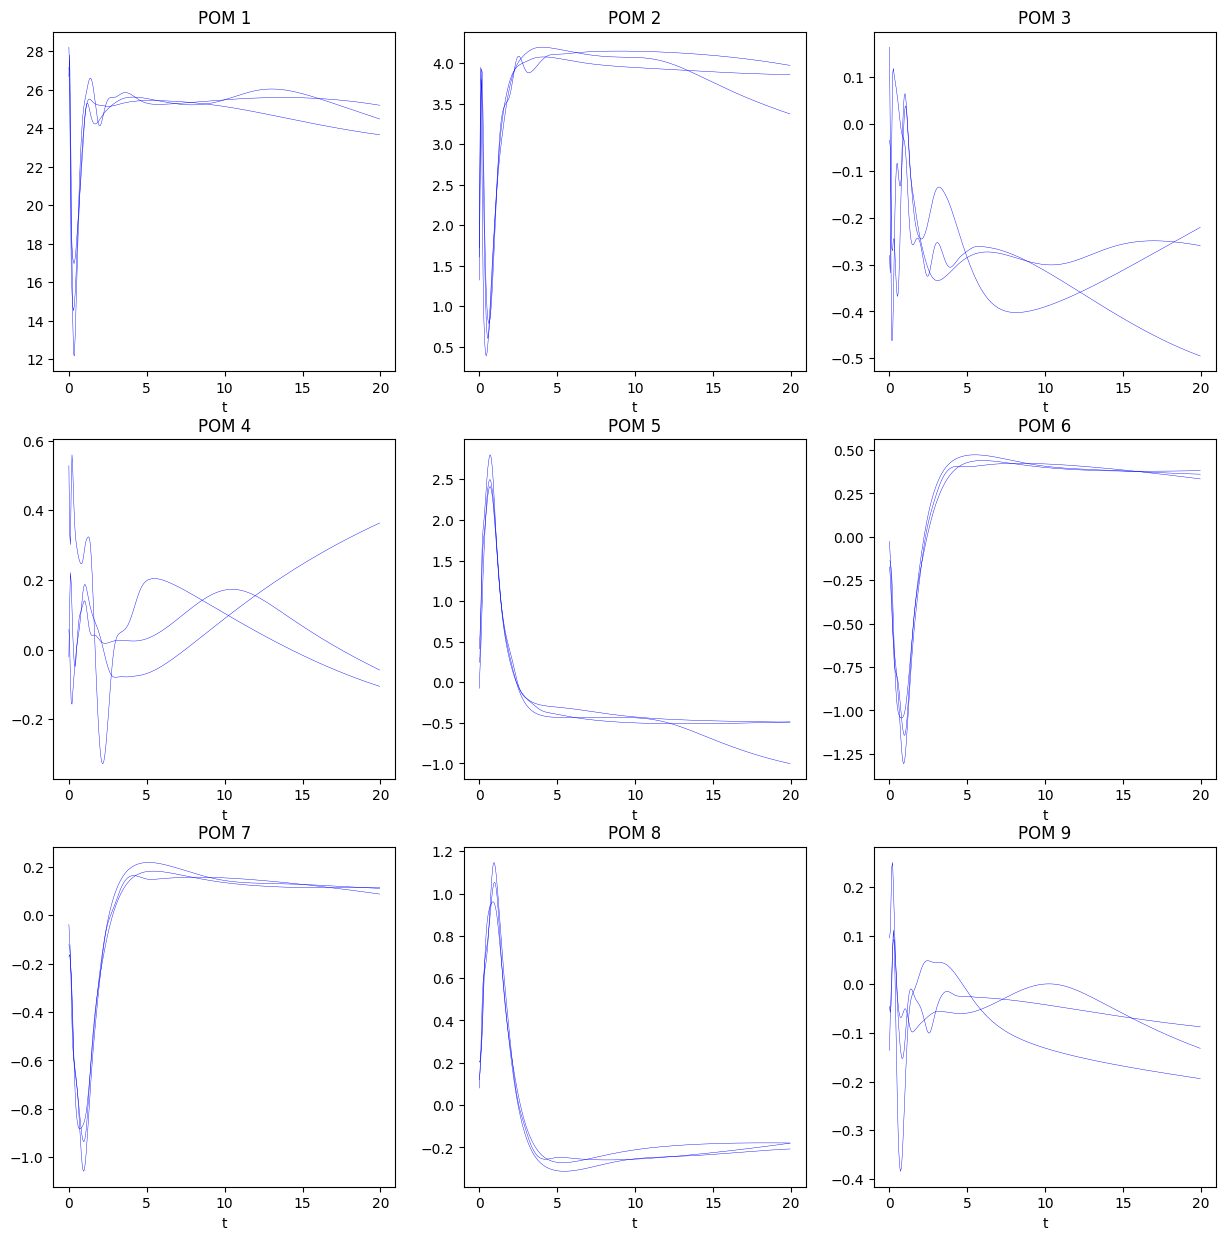

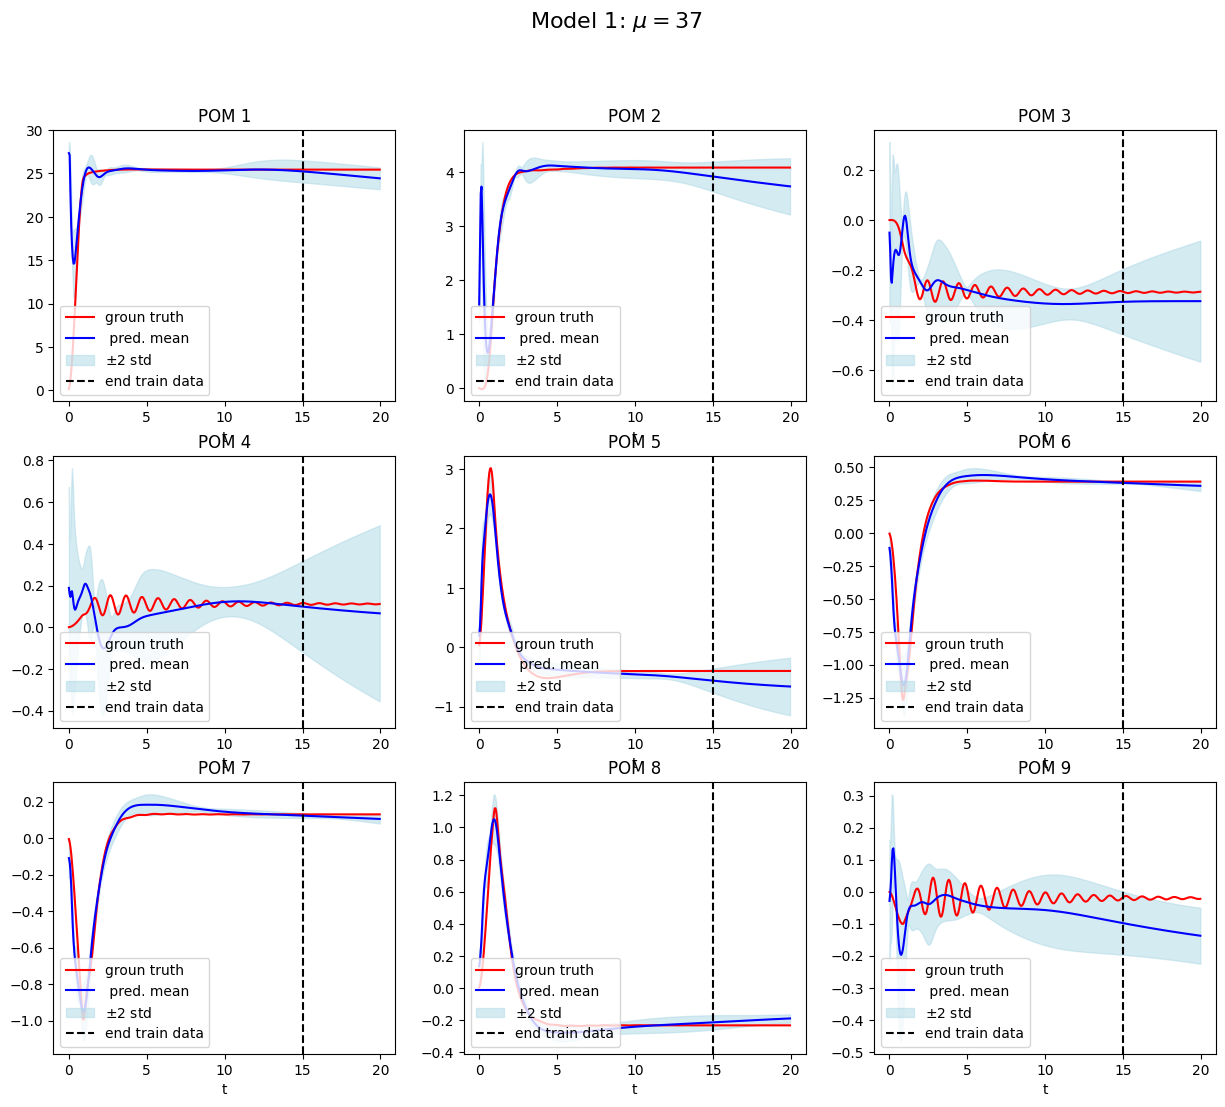

In [8]:
#########################     MODEL 1    ##########################
#########################      TRAIN     ##########################

pred_sim1 = []
model1_list = []

input_dim1 = 2 #(time, parameter)
latent_dim1 = 2 
output_dim1 = n_POD # Number of HF POD modes
idx_test = 0  # show results for the first test parameter

fig = plt.figure(figsize=(15,15))
for i in range(config.N_SIMULATIONS):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=config.HPARAMS['patience'], restore_best_weights=True)

    print('sim ' + str(i+1) + '/' + str(config.N_SIMULATIONS))
    #### MODEL 1 - (time, parameter) -> HF-POD coefficients
    model1 = MultifidelityNetwork(params1, input_dim = input_dim1, latent_dim = latent_dim1, output_dim = output_dim1, prev_models = [], prev_inputs = [])
    name = config.MODEL_PATH + 'model1_sim_' + str(i) 
    if config.TRAIN_MODELS:
        model1.autoencoder.compile(loss=custom_loss,optimizer=params1['opt'])
        tf.random.set_seed(config.SEED + i)
        np.random.seed(config.SEED + i)
        hist1 = model1.autoencoder.fit(x1_lstm_seq,y1_lstm_seq,epochs=params1['Nepo'],batch_size=Nt_train,verbose=1,callbacks=[early_stopping])
    else:
        model1.load_weights(name+ '.weights.h5')

    #Predict and append results
    y_pred1_test = model1.predict(x1_test_lstm) * scale
    pred_sim1.append(y_pred1_test)
    model1_list.append(model1)

    if config.SAVE_MODELS:
        model1.save_weights(name + '.weights.h5')

    # Plot prediction of the first simulation for the ensemble
    for j in range(9):
        ax = plt.subplot(331 + j)
        plt.plot(t_test, y_pred1_test[idx_test,:, j], label = 'HF', color = 'blue',  linewidth = 0.3)
        ax.title.set_text('POM ' + str(j+1))
        plt.xlabel('t')

# Compute mean and std for UQ from the ensemble
mean_sim1 = np.mean(np.array(pred_sim1), axis = 0)
std_sim1 = np.std(np.array(pred_sim1), axis = 0)

# Plot results
fig = plt.figure(figsize=(15,12))
plt.suptitle(f'Model 1: $\mu ={mu_test[idx_test]}$', fontsize = 16)
for i in range(9):
    ax = plt.subplot(331 + i)
    plt.plot(t_test, y1_test_lstm[idx_test,:, i] * scale[i], label = 'groun truth', color = 'red')
    plt.plot(t_test, mean_sim1[idx_test,:, i], label = ' pred. mean', color = 'blue')
    plt.fill_between(t_test, mean_sim1[idx_test,:, i] -2*std_sim1[idx_test,:, i], mean_sim1[idx_test,:, i] + 2*std_sim1[idx_test,:, i], color='lightblue', alpha=0.5, label='$\pm2$ std')
    ax.title.set_text('POM ' + str(i+1))
    plt.xlabel('t')
    plt.axvline(x = T_train, color = 'k', linestyle = '--', label = 'end train data')
    plt.legend(loc = 'lower left')
plt.show()


##Plot reconstruction
# TODO: add reconstruction plots

In [9]:
#########################     MODEL 2    ##########################
#########################   PREPROCESS   ##########################
'''
As second model we consider, in addition to time and parameter information, 
we provide as input the time-history of drag and lift coefficients
'''

if config.SCALING:
    scale_drag = np.max(np.abs(drag_train))
    scale_lift = np.max(np.abs(lift_train))

### Reshape and rescale data
### Input
x2_lstm = np.concatenate((drag_train / scale_drag, lift_train / scale_lift), axis = 2)
x2 = x2_lstm.reshape(-1, x2_lstm.shape[2])
x2_test_lstm = np.concatenate((drag_test / scale_drag, lift_test / scale_lift), axis = 2)

### Output: the ouput is the same (i.e., HF solution)
y2_lstm = y1_lstm 
y2_test_lstm = y1_test_lstm
### Reshape to be suited for time-series
x2_lstm_seq, y2_lstm_seq = sliding_windows(x2_lstm, y2_lstm, config.HPARAMS['sequence_length'], config.HPARAMS['sequence_freq'])

# We keep the same hyperparameters at each level
# We just update the encoder (we use LSTM instead of Dense) as now we are having time-series as inputs
params2 = params1
params2['model_type_encoder'] = 'LSTM'
params2['model_type_decoder'] = 'LSTM'

<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\p'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\p'
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83399/1728936204.py:49: SyntaxWarning: invalid escape sequence '\m'
  plt.suptitle(f'Model 2: $\mu ={mu_test[idx_test]}$', fontsize = 16)
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83399/1728936204.py:54: SyntaxWarning: invalid escape sequence '\p'
  plt.fill_between(t_test, mean_sim2[idx_test,:, i] -2*std_sim2[idx_test,:, i], mean_sim2[idx_test,:, i] + 2*std_sim2[idx_test,:, i], color='lightblue', alpha=0.5, label='$\pm2$ std')


sim 1/3
Loading weights from: ./models/model2_sim_0.weights.h5
sim 2/3
Loading weights from: ./models/model2_sim_1.weights.h5
sim 3/3
Loading weights from: ./models/model2_sim_2.weights.h5


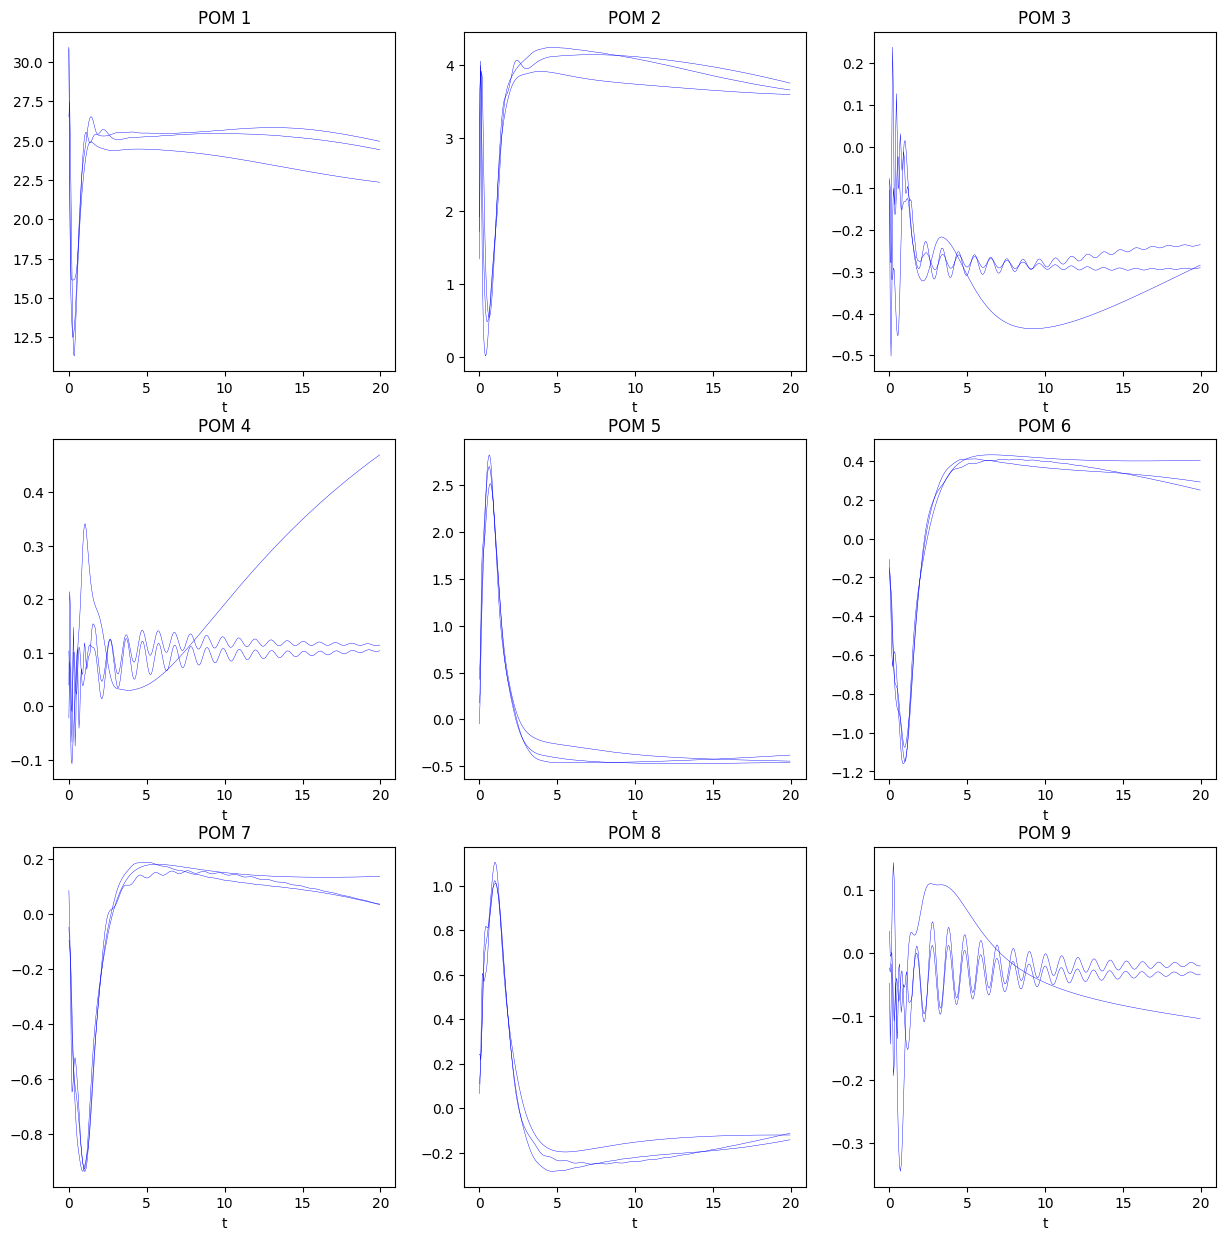

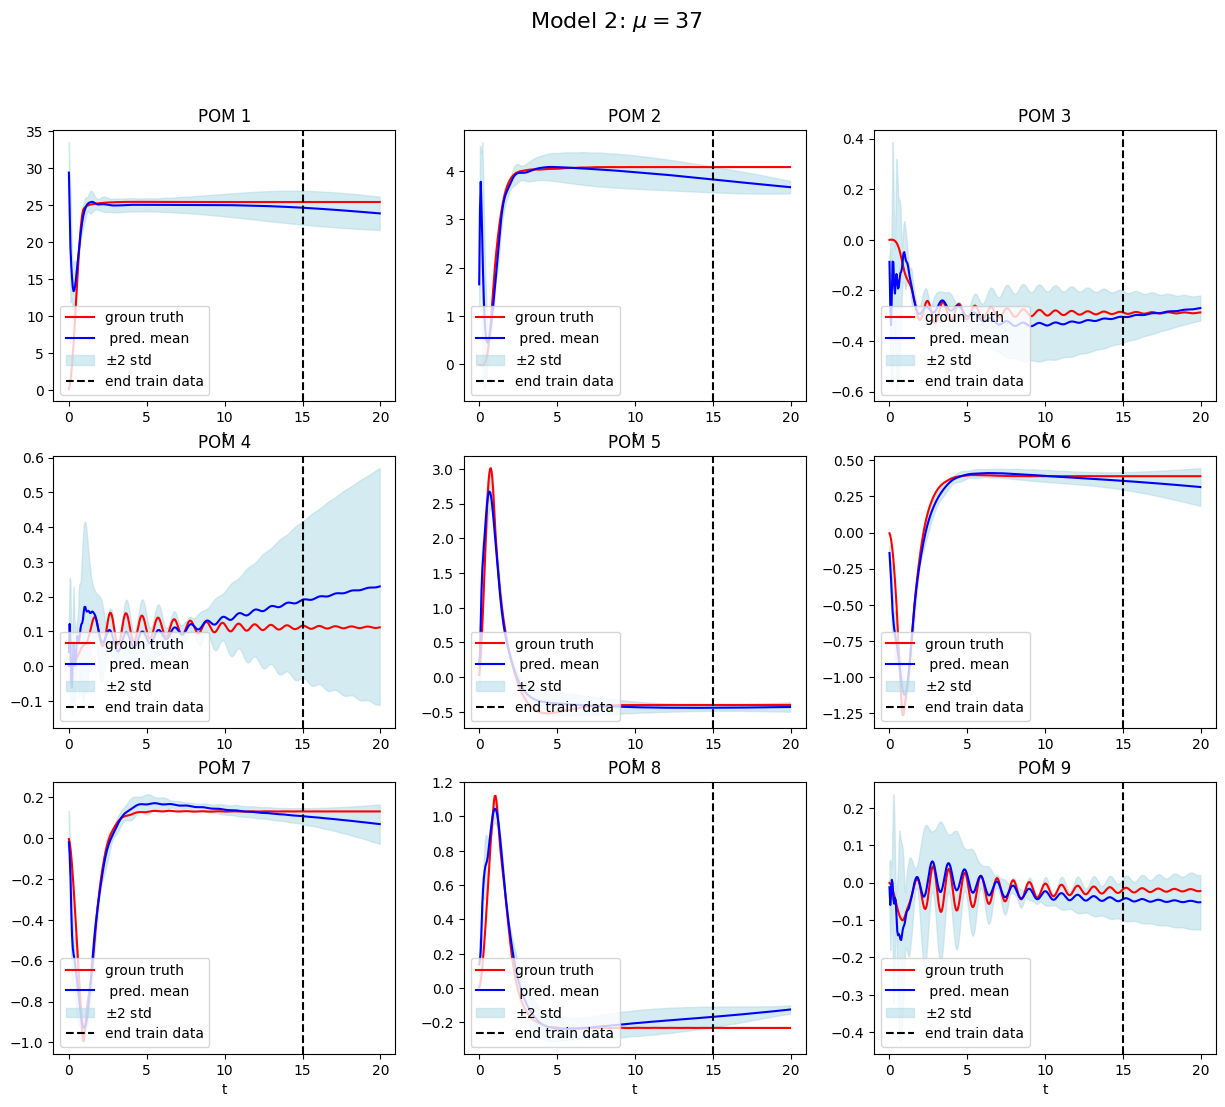

In [10]:
#########################     MODEL 2    ##########################
#########################      TRAIN     ##########################

pred_sim2 = []
model2_list = []

input_dim2 = 2 
latent_dim2 = 2
output_dim2 = n_POD

fig = plt.figure(figsize=(15,15))

for i in range(config.N_SIMULATIONS):
    print('sim ' + str(i+1) + '/' + str(n_sim))
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=config.HPARAMS['patience'], restore_best_weights=True)

    #### MODEL 2 - (time, parameter, sensors) -> HF-POD coefficients
    model2 = MultifidelityNetwork(params2, input_dim = input_dim2, latent_dim = latent_dim2, output_dim = output_dim2, prev_models = [model1_list[i]], prev_inputs = [x1])
    name = config.MODEL_PATH + 'model2_sim_' + str(i)
    if config.TRAIN_MODELS:
        model2.autoencoder.compile(loss=custom_loss,optimizer=params2['opt'])
        tf.random.set_seed(config.SEED + i)
        np.random.seed(config.SEED + i)
        # hist2 = model2.autoencoder.fit(x2,y2,epochs=Nepo,batch_size=N_mu_train,verbose=0,callbacks=[early_stopping])
        hist2 = model2.autoencoder.fit([x1_lstm_seq, x2_lstm_seq],y2_lstm_seq,epochs=params2['Nepo'],batch_size=x2_lstm_seq.shape[0],verbose=1,callbacks=[early_stopping])
    else:
        model2.load_weights(name + '.weights.h5')
    model2_list.append(model2)
    if config.SAVE_MODELS:
        model2.save_weights(name + '.weights.h5')

    #Predict and append results
    y_pred2_test = model2.predict([x1_test_lstm, x2_test_lstm]) * scale
    pred_sim2.append(y_pred2_test)
    
    # Plot prediction of the first simulation for the ensemble
    for j in range(9):
        ax = plt.subplot(331 + j)
        plt.plot(t_test, y_pred2_test[idx_test,:, j], label = 'HF', color = 'blue',  linewidth = 0.3)
        ax.title.set_text('POM ' + str(j+1))
        plt.xlabel('t')

# Compute mean and std for UQ from the ensemble
mean_sim2 = np.mean(np.array(pred_sim2), axis = 0)
std_sim2 = np.std(np.array(pred_sim2), axis = 0)

# Plot results
fig = plt.figure(figsize=(15,12))
plt.suptitle(f'Model 2: $\mu ={mu_test[idx_test]}$', fontsize = 16)
for i in range(9):
    ax = plt.subplot(331 + i)
    plt.plot(t_test, y2_test_lstm[idx_test,:, i] * scale[i], label = 'groun truth', color = 'red')
    plt.plot(t_test, mean_sim2[idx_test,:, i], label = ' pred. mean', color = 'blue')
    plt.fill_between(t_test, mean_sim2[idx_test,:, i] -2*std_sim2[idx_test,:, i], mean_sim2[idx_test,:, i] + 2*std_sim2[idx_test,:, i], color='lightblue', alpha=0.5, label='$\pm2$ std')
    ax.title.set_text('POM ' + str(i+1))
    plt.xlabel('t')
    plt.axvline(x = T_train, color = 'k', linestyle = '--', label = 'end train data')
    plt.legend(loc = 'lower left')
plt.show()



In [11]:
#########################     MODEL 3    ##########################
#########################   PREPROCESS   ##########################
'''
As third level we additionaly consider the time-history of 
outflow dofs and we use LSTM network to process data
'''

outflow_dofs = config.OUTFLOW_DOFS 
outflow_train = u_hf[:,:,outflow_dofs]
outflow_test  = u_hf_test[:,:,outflow_dofs]

#train
x3_lstm = outflow_train
x3 = x3_lstm.reshape(-1, x3_lstm.shape[2])
y3_lstm = uhf_train / scale

#test
x3_test_lstm = outflow_test
y3_test_lstm = uhf_test / scale

# We keep the same hyperparameters at each level
params3 = params1
params3['model_type_encoder'] = 'LSTM'
params3['model_type_decoder'] = 'LSTM'

x3_lstm_seq, y3_lstm_seq = sliding_windows(x3_lstm, y3_lstm, params3['sequence_length'], params3['sequence_freq'])

<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\p'
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83399/3251504754.py:47: SyntaxWarning: invalid escape sequence '\m'
  plt.suptitle(f'Model 3: $\mu ={mu_test[idx_test]}$', fontsize = 16)
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83399/3251504754.py:52: SyntaxWarning: invalid escape sequence '\p'
  plt.fill_between(t_test, mean_sim3[idx_test,:, i] -2*std_sim3[idx_test,:, i], mean_sim3[idx_test,:, i] + 2*std_sim3[idx_test,:, i], color='lightblue', alpha=0.5, label='$\pm2$ std')


sim 1/3
Loading weights from: ./models/model3_sim_0.weights.h5
sim 2/3
Loading weights from: ./models/model3_sim_1.weights.h5
sim 3/3
Loading weights from: ./models/model3_sim_2.weights.h5


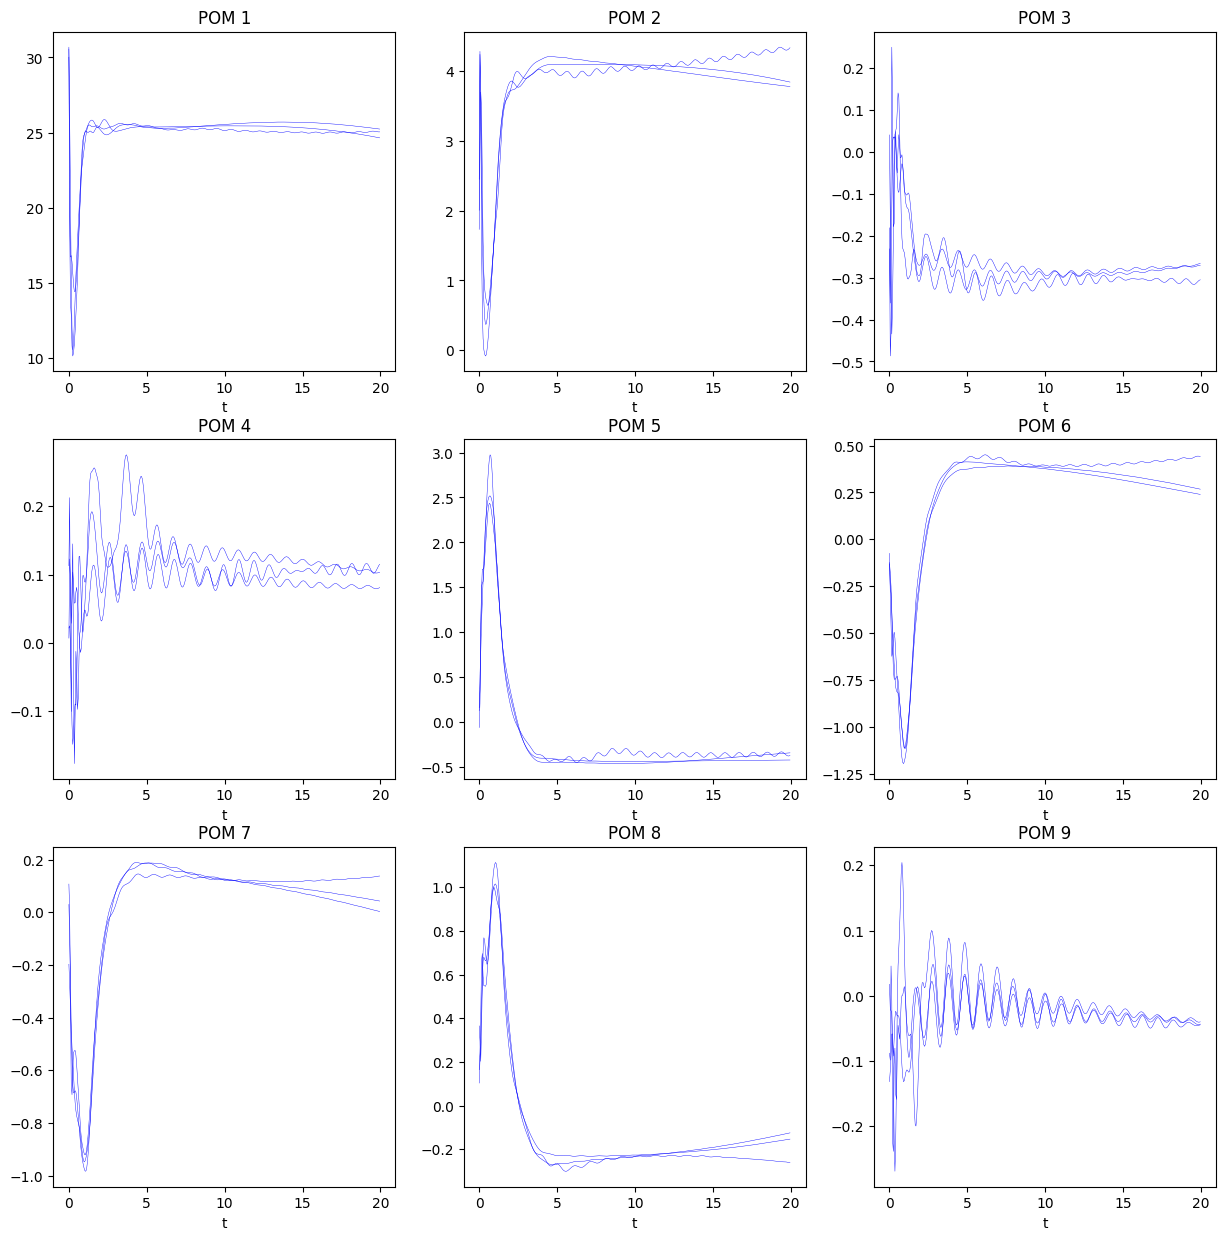

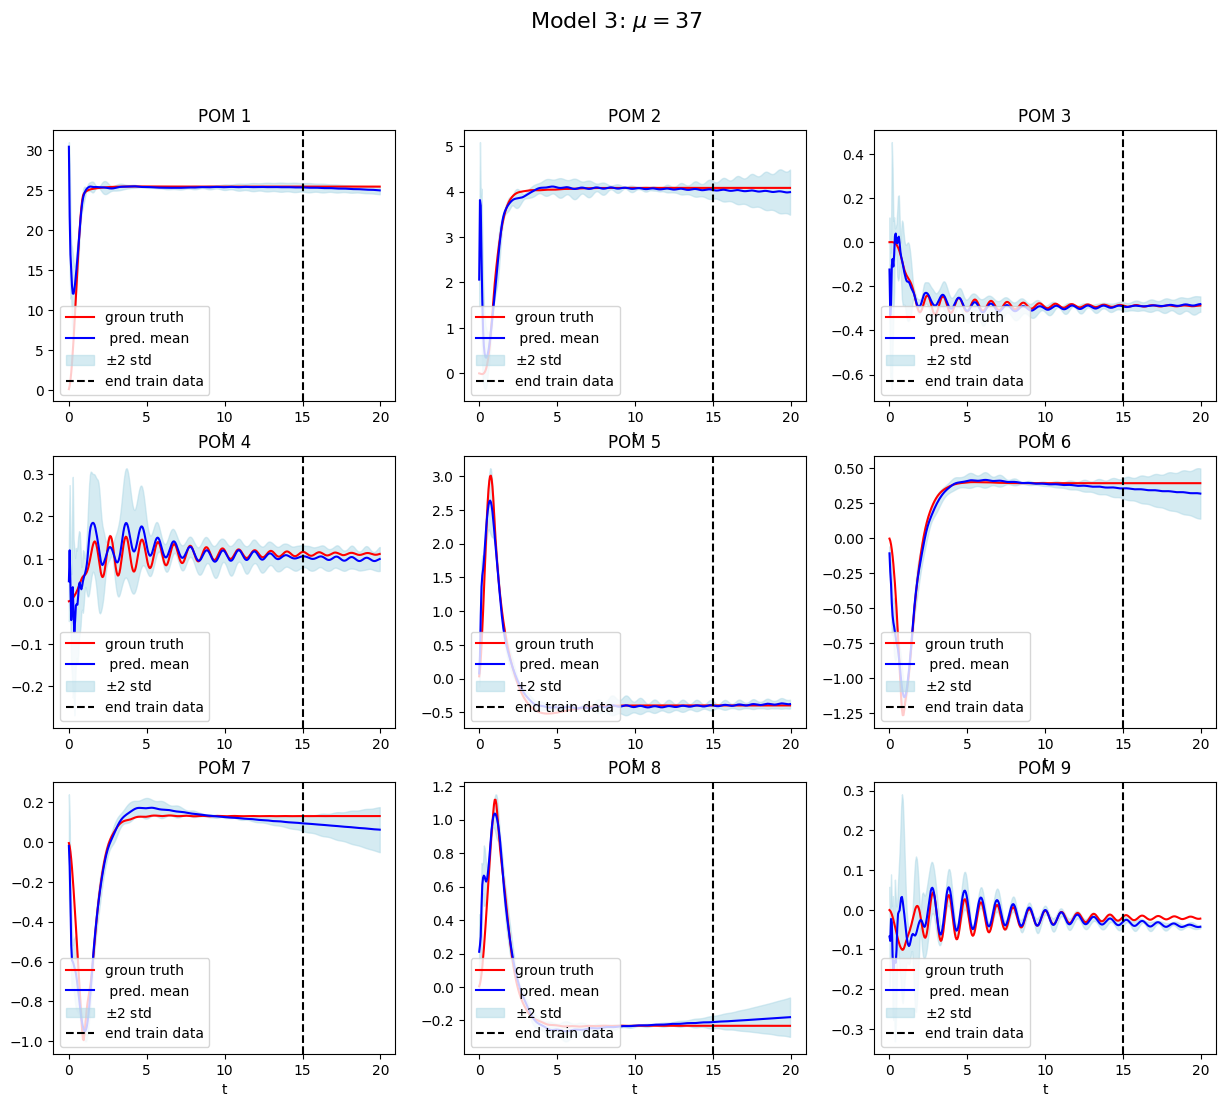

In [12]:
#########################     MODEL 3    ##########################
#########################      TRAIN     ##########################
pred_sim3 = []
pred_sim3_train = []
model3_list = []

input_dim3 = len(outflow_dofs)
latent_dim3 = 2
output_dim3 = n_POD

fig = plt.figure(figsize=(15,15))

for i in range(config.N_SIMULATIONS):
    print('sim ' + str(i+1) + '/' + str(n_sim))
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=config.HPARAMS['patience'], restore_best_weights=True)
    #### MODEL 3 - (time, parameter, sensors, LF-POD coeffs.) -> HF-POD coeffs
    model3 = MultifidelityNetwork(params3, input_dim = input_dim3, latent_dim = latent_dim3, output_dim = output_dim3, prev_models = [model1_list[i], model2_list[i]], prev_inputs = [x1, x2])
    name = config.MODEL_PATH + 'model3_sim_' + str(i)
    if config.TRAIN_MODELS:
        model3.autoencoder.compile(loss=custom_loss,optimizer=params3['opt'])
        tf.random.set_seed(config.SEED + i)
        np.random.seed(config.SEED + i)
        hist3 = model3.autoencoder.fit([x1_lstm_seq, x2_lstm_seq, x3_lstm_seq],y3_lstm_seq,epochs=params3['Nepo'],batch_size=x3_lstm_seq.shape[0],verbose=1,callbacks=[early_stopping])
    else:
        model3.load_weights(name + '.weights.h5')

    if config.SAVE_MODELS:
        model3.save_weights(name + '.weights.h5')
    #Predict and append results
    y_pred3_test = model3.predict([x1_test_lstm, x2_test_lstm, x3_test_lstm]) * scale
    pred_sim3.append(y_pred3_test)
    model3_list.append(model3)
    
    # Plot prediction of the first simulation for the ensemble
    for j in range(9):
        ax = plt.subplot(331 + j)
        plt.plot(t_test, y_pred3_test[idx_test,:, j], label = 'HF', color = 'blue',  linewidth = 0.3)
        ax.title.set_text('POM ' + str(j+1))
        plt.xlabel('t')

# compute mean and std for UQ from the ensemble
mean_sim3 = np.mean(np.array(pred_sim3), axis = 0)
std_sim3 = np.std(np.array(pred_sim3), axis = 0)

# Plot results
fig = plt.figure(figsize=(15,12))
plt.suptitle(f'Model 3: $\mu ={mu_test[idx_test]}$', fontsize = 16)
for i in range(9):  
    ax = plt.subplot(331 + i)
    plt.plot(t_test, y3_test_lstm[idx_test,:, i] * scale[i], label = 'groun truth', color = 'red')
    plt.plot(t_test, mean_sim3[idx_test,:, i], label = ' pred. mean', color = 'blue')
    plt.fill_between(t_test, mean_sim3[idx_test,:, i] -2*std_sim3[idx_test,:, i], mean_sim3[idx_test,:, i] + 2*std_sim3[idx_test,:, i], color='lightblue', alpha=0.5, label='$\pm2$ std')
    ax.title.set_text('POM ' + str(i+1))
    plt.xlabel('t')
    plt.axvline(x = T_train, color = 'k', linestyle = '--', label = 'end train data')
    plt.legend(loc = 'lower left')

In [13]:
#########################     MODEL 4    ##########################
#########################   PREPROCESS   ##########################
'''
As fourth level we additionaly consider the time-history of dofs 
in partial domain close to the cylinder and we use LSTM network to process data
'''

partial_domain_idxs = np.loadtxt(config.DATA_PATH + '/partial_domain_idxs.txt', dtype = int)
partial_domain_train = u_hf[:,:,partial_domain_idxs]
partial_domain_test  = u_hf_test[:,:,partial_domain_idxs]

#train
x4_lstm = partial_domain_train
y4_lstm = uhf_train / scale

# test
x4_test_lstm = partial_domain_test
y4_test_lstm = uhf_test / scale

# We keep the same hyperparameters at each level
params4 = params1
params4['model_type_encoder'] = 'LSTM'
params4['model_type_decoder'] = 'LSTM'  

x4_lstm_seq, y4_lstm_seq = sliding_windows(x4_lstm, y4_lstm, params4['sequence_length'], params4['sequence_freq'])

<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\p'
<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\p'
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83399/3331412513.py:44: SyntaxWarning: invalid escape sequence '\m'
  plt.suptitle(f'Model 4: $\mu ={mu_test[idx_test]}$', fontsize = 16)
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83399/3331412513.py:49: SyntaxWarning: invalid escape sequence '\p'
  plt.fill_between(t_test, mean_sim4[idx_test,:, i] -2*std_sim4[idx_test,:, i], mean_sim4[idx_test,:, i] + 2*std_sim4[idx_test,:, i], color='lightblue', alpha=0.5, label='$\pm2$ std')


sim 1/3
Loading weights from: ./models/model4_sim_0.weights.h5
sim 2/3
Loading weights from: ./models/model4_sim_1.weights.h5
sim 3/3
Loading weights from: ./models/model4_sim_2.weights.h5


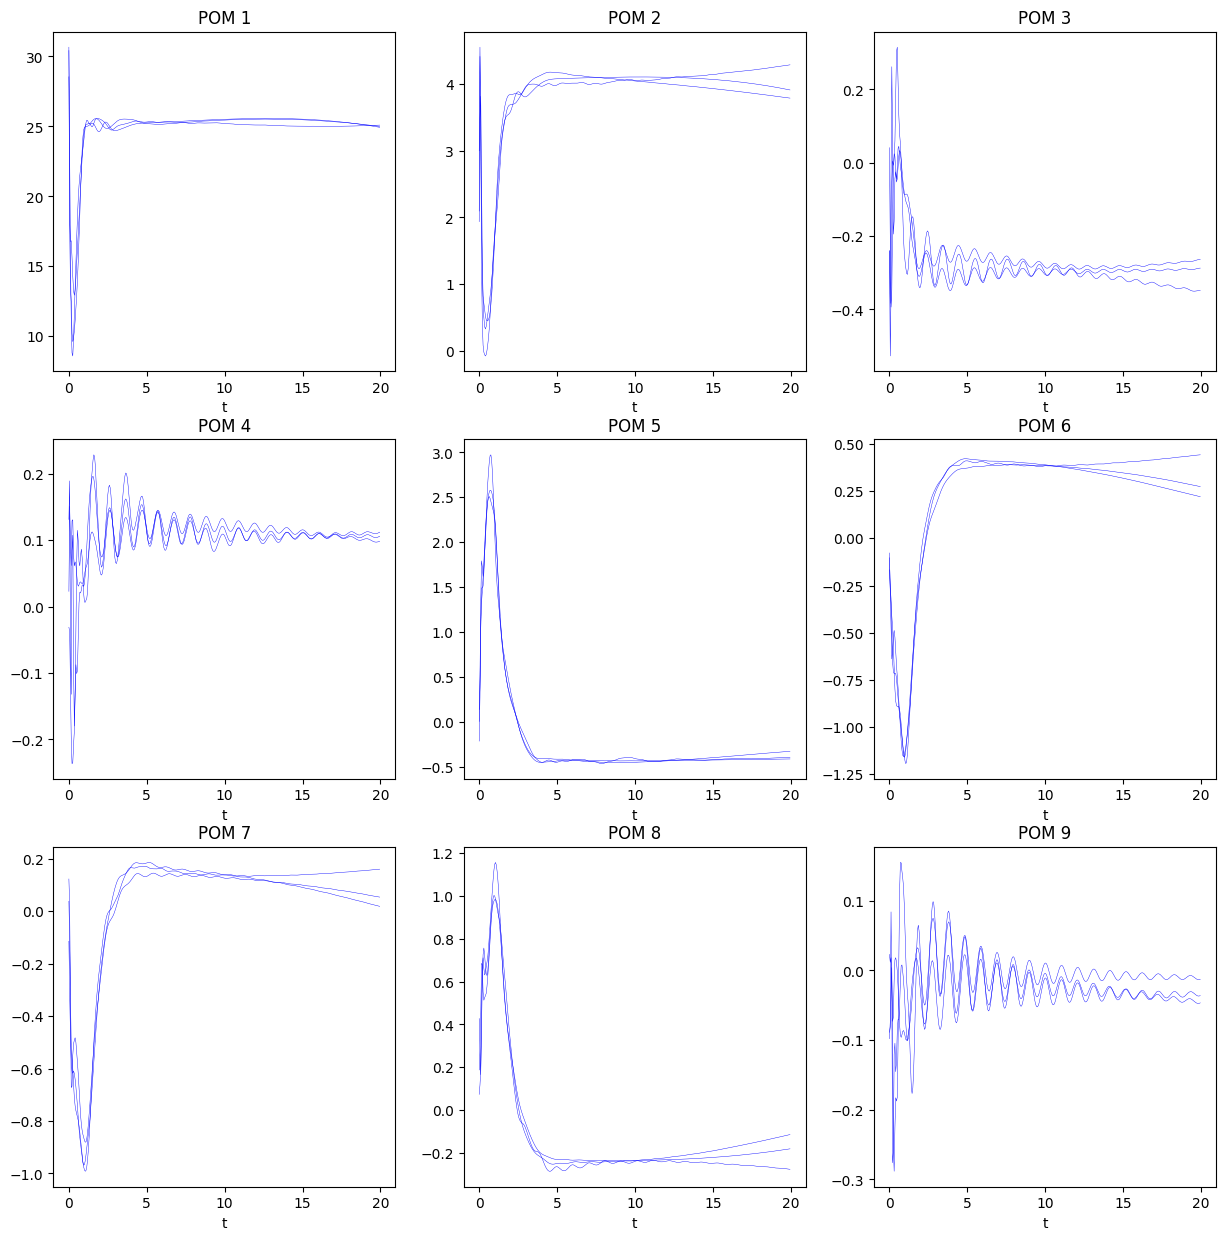

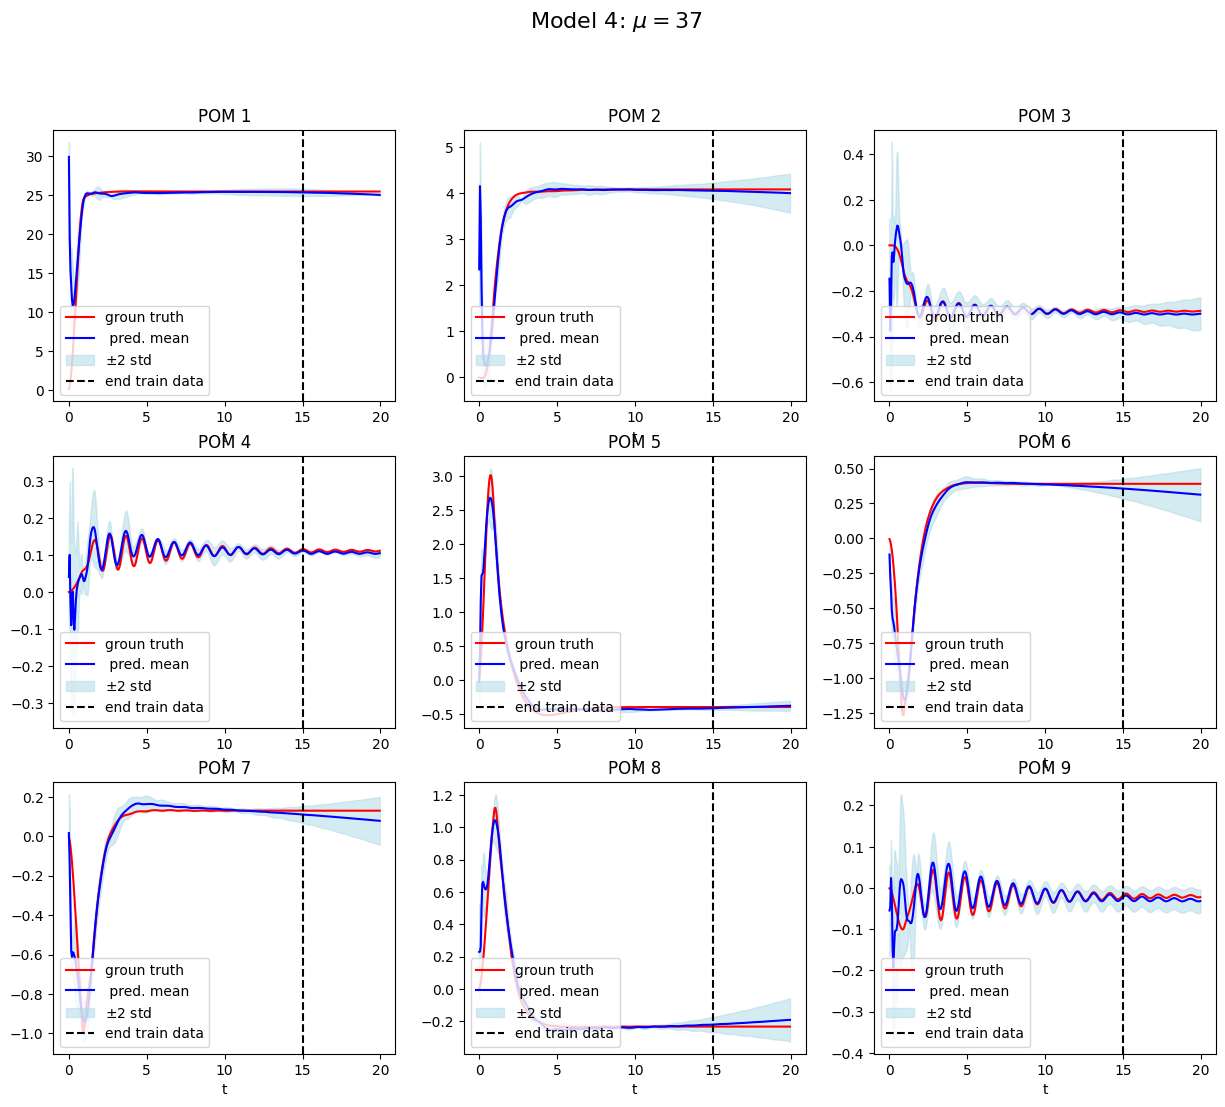

In [14]:
#########################     MODEL 4    ##########################
#########################      TRAIN     ##########################
pred_sim4 = []
model4_list = []
input_dim4 = len(partial_domain_idxs)
latent_dim4 = 2
output_dim4 = n_POD

fig = plt.figure(figsize=(15,15))

for i in range(config.N_SIMULATIONS):
    print('sim ' + str(i+1) + '/' + str(n_sim))
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=config.HPARAMS['patience'], restore_best_weights=True)
    #### MODEL 4 - (time, parameter, sensors, LF-POD coeffs., partial domain dofs) -> HF-POD coeffs
    model4 = MultifidelityNetwork(params4, input_dim = input_dim4, latent_dim = latent_dim4, output_dim = output_dim4, prev_models = [model1_list[i], model2_list[i], model3_list[i]], prev_inputs = [x1, x2, x3])
    name = config.MODEL_PATH + 'model4_sim_' + str(i)
    if config.TRAIN_MODELS:
        model4.autoencoder.compile(loss=custom_loss,optimizer=params4['opt'])
        tf.random.set_seed(config.SEED + i)
        np.random.seed(config.SEED + i)
        hist4 = model4.autoencoder.fit([x1_lstm_seq, x2_lstm_seq, x3_lstm_seq, x4_lstm_seq],y4_lstm_seq,epochs=params4['Nepo'],batch_size=x4_lstm_seq.shape[0],verbose=1,callbacks=[early_stopping])
    else:
        model4.load_weights(name + '.weights.h5')

    if config.SAVE_MODELS:
        model4.save_weights(name + '.weights.h5')
    #Predict and append results
    y_pred4_test = model4.predict([x1_test_lstm, x2_test_lstm, x3_test_lstm, x4_test_lstm]) * scale
    pred_sim4.append(y_pred4_test)
    model4_list.append(model4)
    
    # Plot prediction of the first simulation for the ensemble
    for j in range(9):
        ax = plt.subplot(331 + j)
        plt.plot(t_test, y_pred4_test[idx_test,:, j], label = 'HF', color = 'blue',  linewidth = 0.3)
        ax.title.set_text('POM ' + str(j+1))
        plt.xlabel('t')

# compute mean and std for UQ from the ensemble
mean_sim4 = np.mean(np.array(pred_sim4), axis = 0)
std_sim4 = np.std(np.array(pred_sim4), axis = 0)            
# Plot results
fig = plt.figure(figsize=(15,12))
plt.suptitle(f'Model 4: $\mu ={mu_test[idx_test]}$', fontsize = 16)
for i in range(9):  
    ax = plt.subplot(331 + i)
    plt.plot(t_test, y4_test_lstm[idx_test,:, i] * scale[i], label = 'groun truth', color = 'red')
    plt.plot(t_test, mean_sim4[idx_test,:, i], label = ' pred. mean', color = 'blue')
    plt.fill_between(t_test, mean_sim4[idx_test,:, i] -2*std_sim4[idx_test,:, i], mean_sim4[idx_test,:, i] + 2*std_sim4[idx_test,:, i], color='lightblue', alpha=0.5, label='$\pm2$ std')
    ax.title.set_text('POM ' + str(i+1))
    plt.xlabel('t')
    plt.axvline(x = T_train, color = 'k', linestyle = '--', label = 'end train data')
    plt.legend(loc = 'lower left')
plt.show()

<>:30: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\p'
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83399/4237297804.py:30: SyntaxWarning: invalid escape sequence '\p'
  color='skyblue', alpha=0.7, label='mean $\pm$ std')


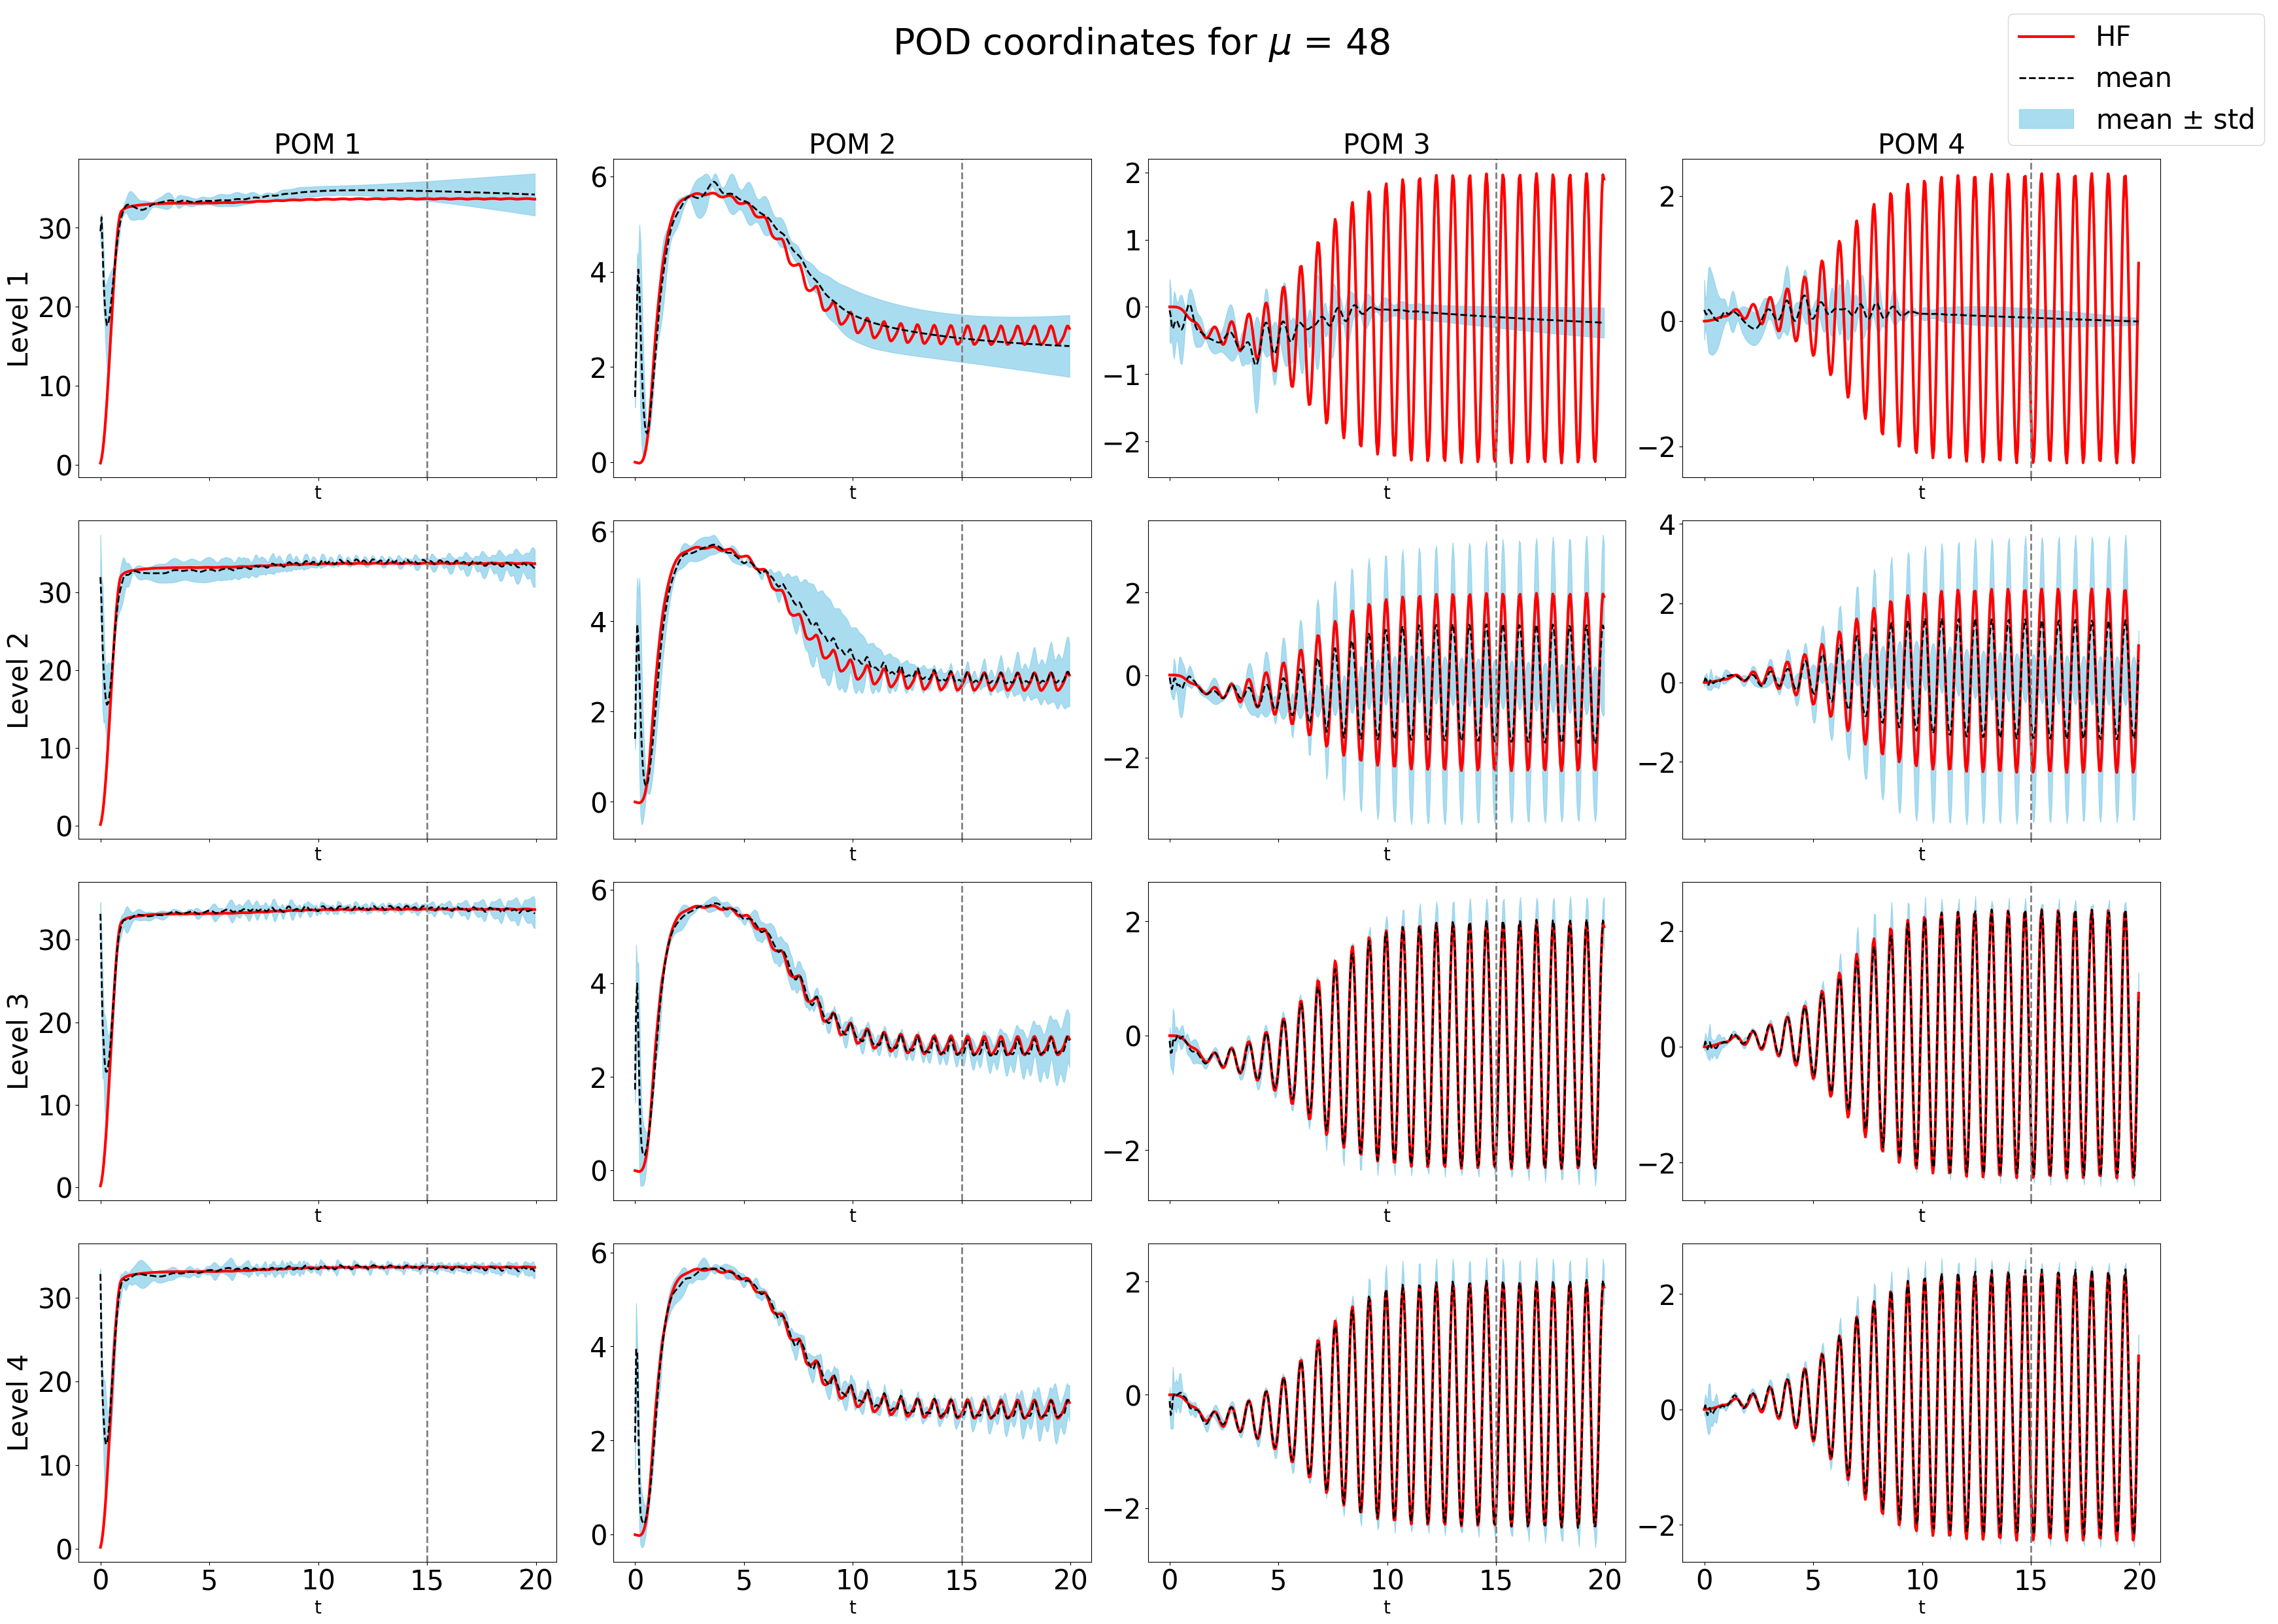

In [15]:
##########################   RESULTS POD COORDINATES   ##########################
idx_test = mu = 1

levels = {
    "Level 1": (mean_sim1, std_sim1),
    "Level 2": (mean_sim2, std_sim2),
    "Level 3": (mean_sim3, std_sim3),
    "Level 4": (mean_sim4, std_sim4),
}

fig, axes = plt.subplots(
    nrows=4, ncols=4, figsize=(35, 25), sharex=True, sharey=False
)
fig.suptitle(r'POD coordinates for $\mu$ = ' + str(mu_test[mu].round(3)), fontsize=40)

for row, (level_name, (mean_sim, std_sim)) in enumerate(levels.items()):
    for POD_mode in range(4):
        ax = axes[row, POD_mode]
        
        # HF curve
        ax.plot(t_test, y1_test_lstm[idx_test,:Nt_test, POD_mode] * scale[POD_mode],
                label='HF', color='red', linewidth=3)
        
        # Mean + std
        ax.plot(t_test, mean_sim[idx_test,:Nt_test, POD_mode],
                label='mean', color='black', linestyle='--', linewidth=2)
        ax.fill_between(t_test,
                        mean_sim[idx_test,:Nt_test, POD_mode] - 2*std_sim[idx_test,:Nt_test, POD_mode],
                        mean_sim[idx_test,:Nt_test, POD_mode] + 2*std_sim[idx_test,:Nt_test, POD_mode],
                        color='skyblue', alpha=0.7, label='mean $\pm$ std')
        
        # Training cutoff
        ax.axvline(x=T_train, linestyle='--', color='gray', linewidth=2)
        
        # Titles only on top row
        if row == 0:
            ax.set_title(f'POM {POD_mode + 1}', fontsize=30)
        # Y-label only on first column
        if POD_mode == 0:
            ax.set_ylabel(level_name, fontsize=30)
        
        ax.tick_params(axis='both', which='major', labelsize=30)
        ax.set_xlabel('t', fontsize=20)

# Add legend only once
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=30)

plt.tight_layout(rect=[0, 0, .95, 0.95])
plt.savefig(config.FIGURE_PATH + 'results_POD_NavierStokes.svg', dpi=600, bbox_inches='tight')
plt.show()

In [16]:
##########################   RECONSTRUCTION   ##########################
u_pred4 = (mean_sim4 @ POM_u.T)
u_pred3 = (mean_sim3 @ POM_u.T)
u_pred2 = (mean_sim2 @ POM_u.T)
u_pred1 = (mean_sim1 @ POM_u.T)

u_true = u_hf_test

print('Reconstruction errors:')
err_1_pod =  np.linalg.norm((mean_sim1 - y1_test_lstm * scale) ) / np.linalg.norm(y1_test_lstm * scale)
err_2_pod =  np.linalg.norm((mean_sim2 - y2_test_lstm * scale) ) / np.linalg.norm(y2_test_lstm * scale)
err_3_pod =  np.linalg.norm((mean_sim3 - y3_test_lstm * scale) ) / np.linalg.norm(y3_test_lstm * scale)
err_4_pod =  np.linalg.norm((mean_sim4 - y4_test_lstm * scale) ) / np.linalg.norm(y4_test_lstm * scale)
print("POD Coefficients Error Level 1: ", err_1_pod * 100, "%")
print("POD Coefficients Error Level 2: ", err_2_pod * 100, "%")
print("POD Coefficients Error Level 3: ", err_3_pod * 100, "%")
print("POD Coefficients Error Level 4: ", err_4_pod * 100, "%")

err_1 = np.linalg.norm(u_pred1 - u_true) / np.linalg.norm(u_true)
err_2 = np.linalg.norm(u_pred2 - u_true) / np.linalg.norm(u_true)
err_3 = np.linalg.norm(u_pred3 - u_true) / np.linalg.norm(u_true)
err_4 = np.linalg.norm(u_pred4 - u_true) / np.linalg.norm(u_true)
print("Error Level 1: ", err_1 * 100, "%")
print("Error Level 2: ", err_2 * 100, "%")
print("Error Level 3: ", err_3 * 100, "%")
print("Error Level 4: ", err_4 * 100, "%")

Reconstruction errors:
POD Coefficients Error Level 1:  12.306786839907863 %
POD Coefficients Error Level 2:  8.686552287073608 %
POD Coefficients Error Level 3:  6.769158602980592 %
POD Coefficients Error Level 4:  6.43730109502788 %
Error Level 1:  12.336797536384221 %
Error Level 2:  8.729345279438506 %
Error Level 3:  6.8241491751507555 %
Error Level 4:  6.495127271593559 %


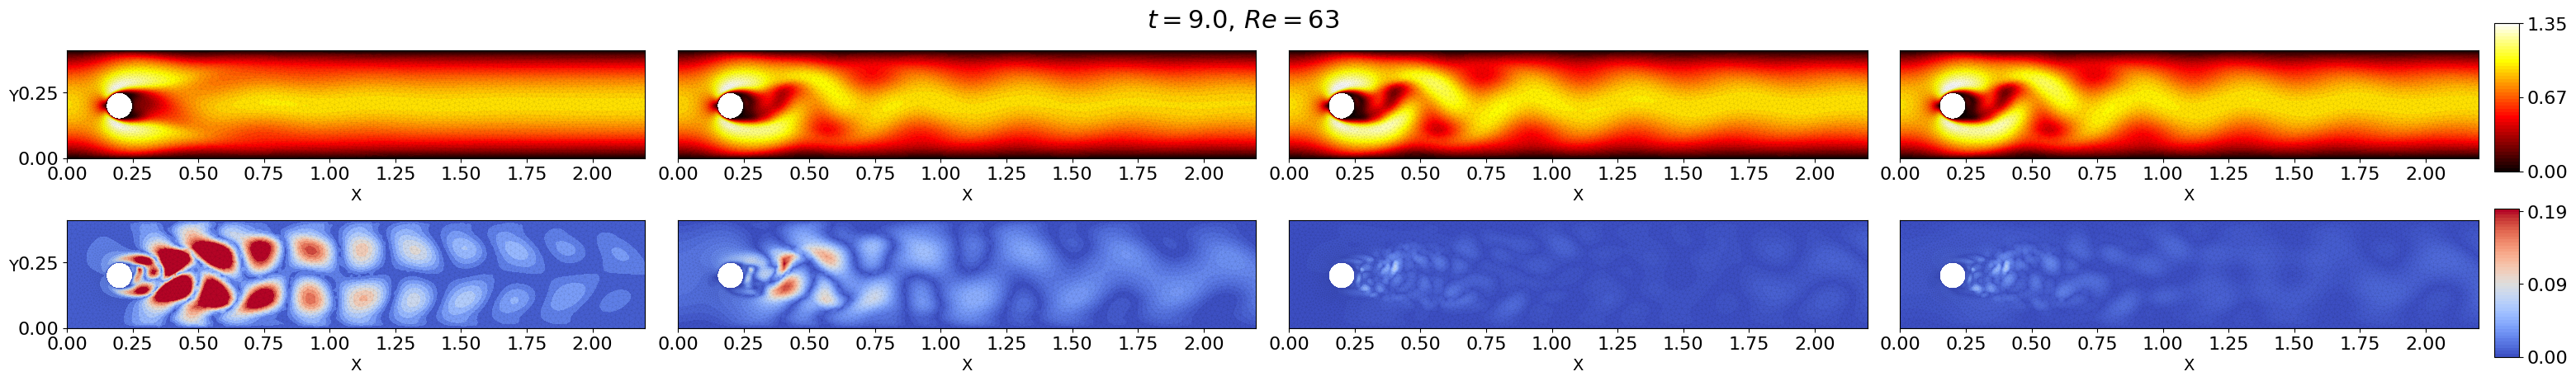

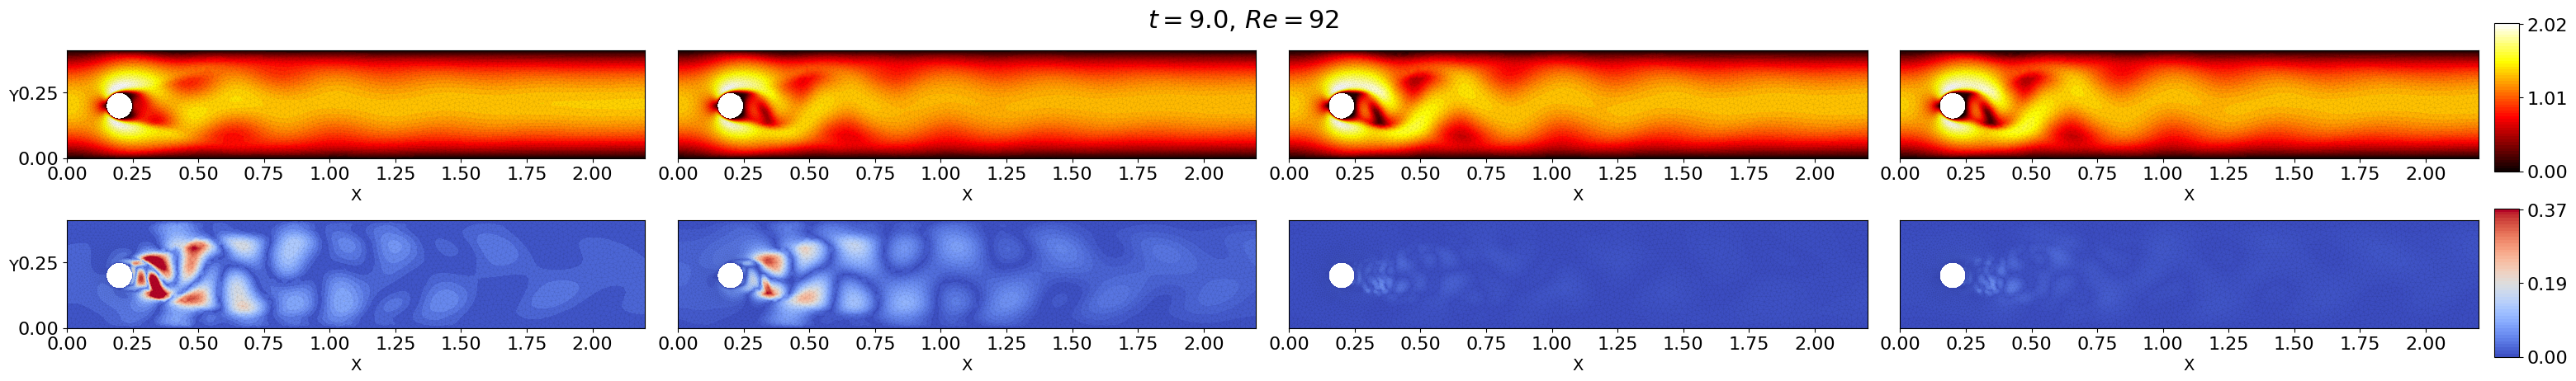

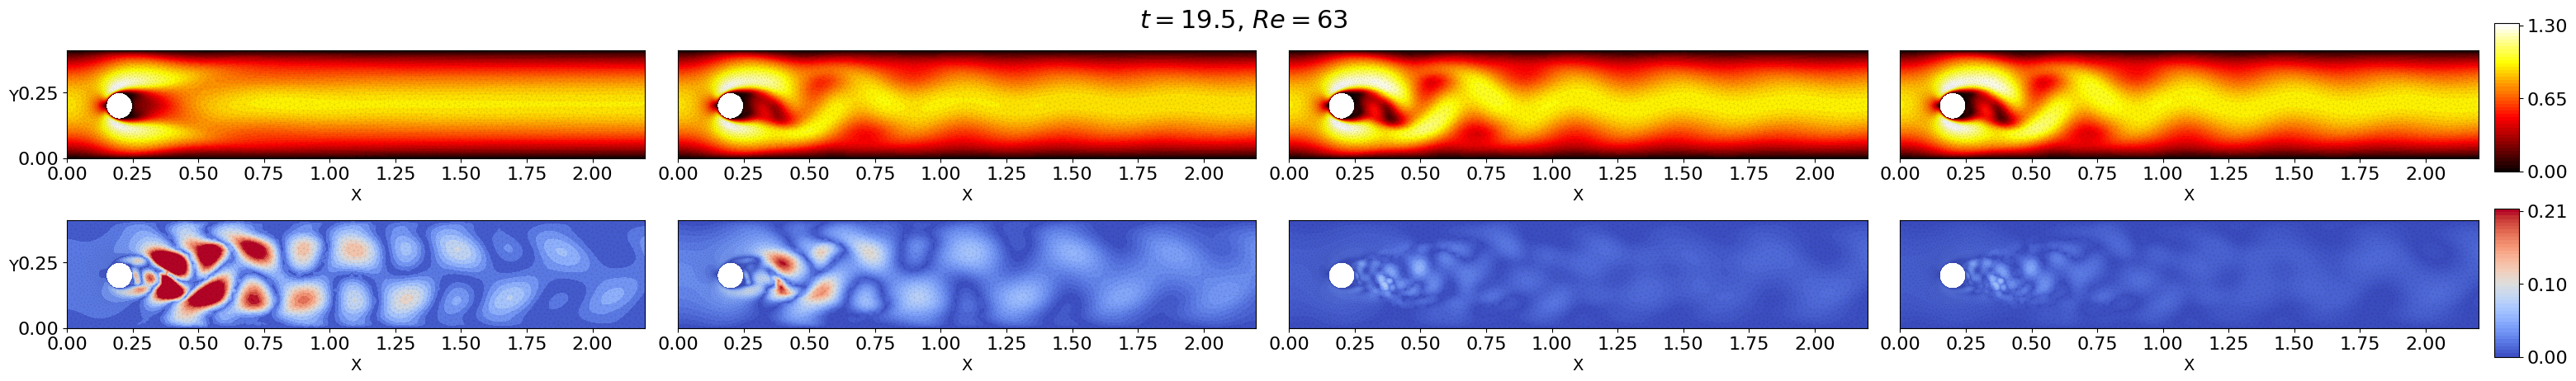

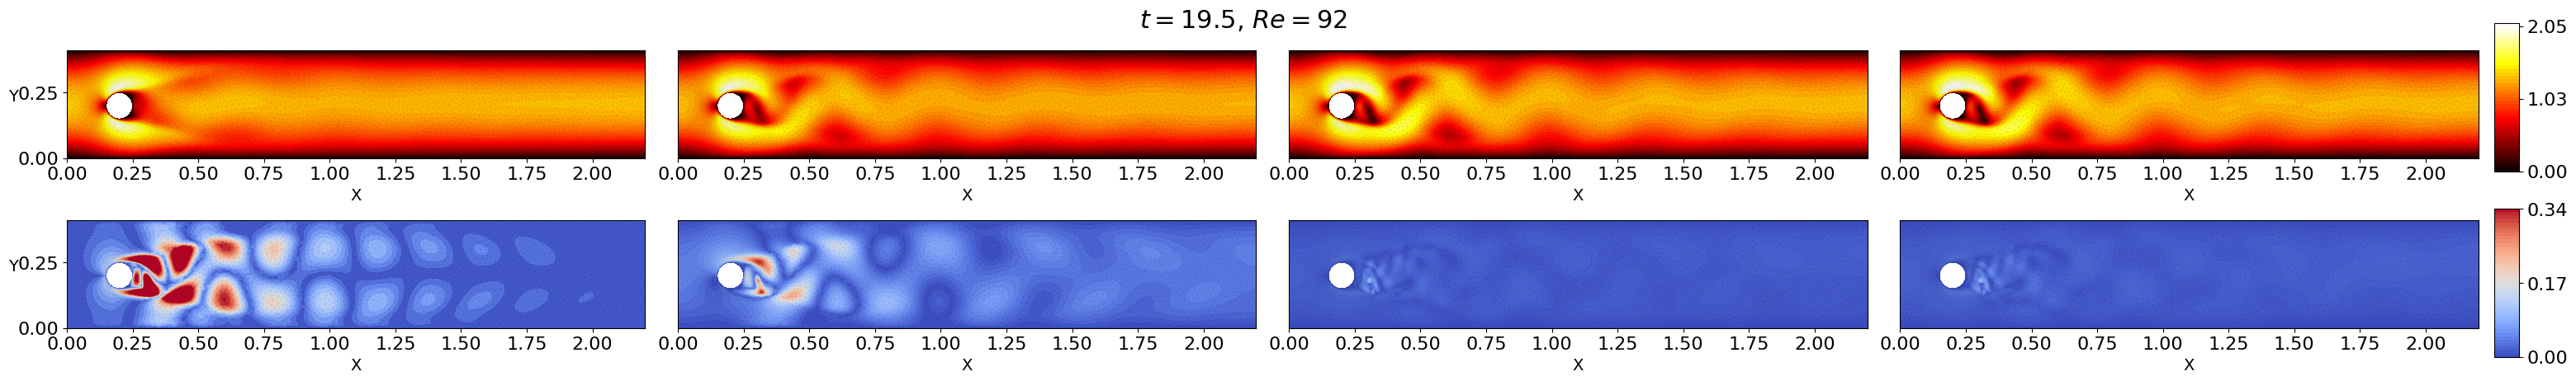

In [17]:
########################   PLOTTING RECONSTRUCTIONS   #######################
vertices, connectivity, elem_centers, triangulation = load_mesh(config.DATA_PATH + "obstacleDFG_Coarse.msh")

timesteps = [180, 390]
n_simulations = [2, 4]

err_abs_1 = np.abs(u_pred1 - u_true)
err_abs_2 = np.abs(u_pred2 - u_true)
err_abs_3 = np.abs(u_pred3 - u_true)
err_abs_4 = np.abs(u_pred4 - u_true)

recs = [u_pred1, u_pred2, u_pred3, u_pred4]
errs = [err_abs_1, err_abs_2, err_abs_3, err_abs_4]

cmap_rec = "hot"
cmap_err = "coolwarm"

for timestep in timesteps:
    for n_simulation in n_simulations:

        # Fix color scales relative to current sim+timestep (based on rec2)
        vmax_rec = np.max(recs[1][n_simulation, timestep, :])
        vmax_err = np.max(errs[1][n_simulation, timestep, :])

        # Create new figure
        fig, axes = plt.subplots(2, 4, figsize=(30, 4.5), constrained_layout=True)

        for col in range(4):
            # Predictions
            plot_snapshot(
                recs[col],
                timestep=timestep,
                n_simulation=n_simulation,
                triangulation=triangulation,
                vertices=vertices,
                connectivity=connectivity,
                ax=axes[0, col],
                cmap=cmap_rec,
                minmax=(0, vmax_rec),
                show_colorbar=False,
                show_y=(col == 0)
            )

            # Errors
            plot_snapshot(
                errs[col],
                timestep=timestep,
                n_simulation=n_simulation,
                triangulation=triangulation,
                vertices=vertices,
                connectivity=connectivity,
                ax=axes[1, col],
                cmap=cmap_err,
                minmax=(0, vmax_err),
                show_colorbar=False,
                show_y=(col == 0)
            )

            axes[0, col].tick_params(axis="both", labelsize=16)
            axes[1, col].tick_params(axis="both", labelsize=16)

        bbox_top = axes[0, 3].get_position()
        bbox_bot = axes[1, 3].get_position()
        cb_width = 0.01
        cb_height = 0.4
        cb_padding = 0.105

        # Top row colorbar (predictions)
        cax_top = fig.add_axes([bbox_top.x1 + cb_padding, 0.55, cb_width, cb_height])
        cf_top = axes[0, 1].collections[0]
        cb_top = fig.colorbar(cf_top, cax=cax_top)
        cb_top.set_ticks([0, vmax_rec / 2, vmax_rec])
        cb_top.set_ticklabels([f"{v:.2f}" for v in [0, vmax_rec / 2, vmax_rec]])
        cb_top.ax.tick_params(labelsize=16)

        # Bottom row colorbar (errors)
        cax_bot = fig.add_axes([bbox_bot.x1 + cb_padding, 0.05, cb_width, cb_height])
        cf_bot = axes[1, 1].collections[0]
        cb_bot = fig.colorbar(cf_bot, cax=cax_bot)
        cb_bot.set_ticks([0, vmax_err / 2, vmax_err])
        cb_bot.set_ticklabels([f"{v:.2f}" for v in [0, vmax_err / 2, vmax_err]])
        cb_bot.ax.tick_params(labelsize=16)

        # Title
        fig.suptitle(f"$t={t_test[timestep]}$, $Re= {mu_test[n_simulation]}$", fontsize=22)

        # Save (SVG)
        fig.savefig(
            f"{config.FIGURE_PATH}/pred_err_comparison_{timestep}_{n_simulation}.svg",
            dpi=300,
            bbox_inches="tight"
        )

        plt.show()